In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')


fake_df = pd.read_csv('/content/drive/MyDrive/Fake.csv', on_bad_lines='skip', encoding="utf-8")
true_df = pd.read_csv('/content/drive/MyDrive/True.csv', on_bad_lines='skip', encoding="utf-8")


Mounted at /content/drive


In [4]:
from sklearn.utils import resample
import pandas as pd

min_len = len(true_df)
fake_df = fake_df.sample(n=min_len, random_state=42)


In [5]:
fake_df['label'] = 0
true_df['label'] = 1


In [6]:
data = pd.concat([fake_df, true_df], axis=0)
data = data[['text', 'label']]


data = data.sample(frac=1).reset_index(drop=True)


In [7]:
def preprocess_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')
    return text

data['text'] = data['text'].apply(preprocess_text)


In [8]:
max_words = 5000
max_len = 500
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [9]:

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, data['label'], test_size=0.2, random_state=42)

In [10]:
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [12]:
epochs = 3
batch_size = 64

history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/3
536/536 ━━━━━━━━━━━━━━━━━━━━ 914s 2s/step - accuracy: 0.6709 - loss: 0.5598 - val_accuracy: 0.9101 - val_loss: 0.2960
Epoch 2/3
536/536 ━━━━━━━━━━━━━━━━━━━━ 910s 2s/step - accuracy: 0.9030 - loss: 0.2991 - val_accuracy: 0.9342 - val_loss: 0.2169
Epoch 3/3
536/536 ━━━━━━━━━━━━━━━━━━━━ 918s 2s/step - accuracy: 0.9210 - loss: 0.2470 - val_accuracy: 0.9527 - val_loss: 0.1479


In [13]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

268/268 ━━━━━━━━━━━━━━━━━━━━ 75s 278ms/step - accuracy: 0.9539 - loss: 0.1452

Test Accuracy: 95.27%


268/268 ━━━━━━━━━━━━━━━━━━━━ 73s 272ms/step


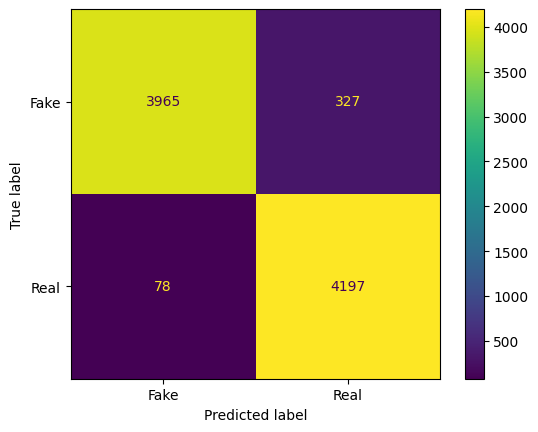

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_probs = model.predict(X_test)
y_pred = (y_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot()


In [15]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


              precision    recall  f1-score   support

        Fake       0.98      0.92      0.95      4292
        Real       0.93      0.98      0.95      4275

    accuracy                           0.95      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.95      0.95      0.95      8567



In [16]:
import numpy as np

def predict_news(news_text):

    news_text = news_text.lower()
    news_text = news_text.replace('\n', ' ')


    sequence = tokenizer.texts_to_sequences([news_text])
    padded_sequence = pad_sequences(sequence, maxlen=500, padding='post', truncating='post')


    prediction = model.predict(padded_sequence)[0][0]
    confidence = prediction * 100


    if prediction >= 0.75:
        label = "📰 Real News ✅"
    elif prediction >= 0.6:
        label = "🟢 Possibly Real News 🤔"
    elif prediction >= 0.4:
        label = "🟠 Possibly Fake News ⚠️"
    else:
        label = "🚨 Fake News ❌"
        confidence = 100 - confidence


    print(f"\n🔍 Prediction: {label}\n📊 Confidence: {confidence:.2f}%")

news_article = """South Korea’s Constitutional Court Friday removed impeached President Yoon Suk Yeol from office. The verdict also upheld the National Assembly’s impeachment vote in December as his martial law declaration had “grave negative impact” on the constitutional order.

In a nationally televised judgement, at least six out of eight justices ruled in favour of Yoon’s removal.

“Given the grave negative impact on constitutional order and the significant ripple effects of the defendant’s violations, we find that the benefits of upholding the constitution by removing the defendant from office far outweigh the national losses from the removal of a president,” the court’s acting chief Moon Hyung-bae said.

Story continues below this ad
PlayUnmute
Fullscreen

The ruling ends his tumultuous presidency four months after he threw South Korean politics into turmoil and necessitates a new presidential election within two months.

STORIES YOU MAY LIKE
Ram Madhav writes: Globalism is over. India must be a regional leader
‘Wake up,’ says Pakistan’s media to its government as Trump slaps 29 per cent tariff
Dismissed police inspector found guilty in Ashwini Bidre murder case
“The defendant not only declared martial law, but also violated the constitution and laws by mobilising military and police forces to obstruct the exercise of legislative authority. Ultimately, the declaration of martial law in this case violated the substantive requirements for emergency martial law,” the justice added.

The move is expected to reshape South Korea’s political landscape, particularly as his supporters continue to rally behind him.Meanwhile, the military has heightened its surveillance, raising concerns over potential unrest.

South Korea’s interim leader urged the nation on Wednesday to remain calm and accept the Constitutional Court’s impending ruling on President Yoon Suk Yeol’s impeachment.

Story continues below this ad

South Korea Members of the Federation of Korean Trade Unions hold up cards during a rally calling for impeached South Korean President Yoon Suk Yeol to step down in Seoul, South Korea. (AP photo)
During a ministerial meeting focused on safety before the landmark decision, acting President Han Duck-soo stressed the importance of maintaining order and urged politicians to avoid statements that could provoke unrest. “The government will not tolerate any illegal or violent acts. No matter what decision is made, we must accept the results calmly based on the rule of law,” Han stated.

“If we can become one again with your strength and wisdom, we can overcome this crisis of confusion and conflicts,” he added.

South Korea The letters read ‘Yoon Suk Yeol’s immediate dismissal.’ (AP photo)
What led to Yoon’s impeachment?
Yoon’s impeachment originated from a political crisis sparked by his declaration of martial law on 3 December 2024.

Amid a fierce legislative deadlock with the opposition-controlled National Assembly, Yoon deployed hundreds of military troops and police officers to government sites, including the National Assembly and election offices. He defended the move as a necessary measure to restore order and expose what he described as the opposition’s “wickedness” in obstructing governance.

Story continues below this ad

Also Read: | South Korea’s impeached president Yoon released from detention
However, opposition leaders and legal experts condemned the move as an unconstitutional power grab, accusing Yoon of attempting to suppress democracy and unlawfully detain lawmakers. His martial law order lasted only six hours before the legislature swiftly voted to revoke it, but the consequences were immediate.

South Korea Police officers move as protesters prepare to march toward the Constitutional Court during a rally calling for impeached South Korean President Yoon Suk Yeol to step down near the Gwanghwamun, Seoul. (AP photo)
By the end of December, the National Assembly formally impeached Yoon, resulting in an automatic suspension of his presidential powers as the Constitutional Court reviewed the case.

The impeachment motion charged Yoon with violating the constitution, obstructing legislative functions, and undermining democratic institutions. Millions took to the streets—some in support of Yoon, while others demanded his permanent removal.

Story continues below this ad

How the public reacted?
South Korea Yoon’s impeachment was driven by the political upheaval following his declaration of martial law on 3 December 2024. (AP photo)
The ruling has triggered intense reactions on both sides. Thousands of Yoon’s supporters and opponents gathered in downtown Seoul in anticipation of the verdict. The government deployed hundreds of police buses, barricades, and officers to prevent potential clashes.

mail logo
Daily newsletter specially tailored for Indian Express global readers

Enter Your Email

At a large anti-Yoon demonstration, protesters cheered and waved banners backing opposition leader Lee Jae-myung, while others watched the court proceedings on a giant screen, documenting the moment on their phones.
"""
predict_news(news_article)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step

🔍 Prediction: 📰 Real News ✅
📊 Confidence: 83.55%


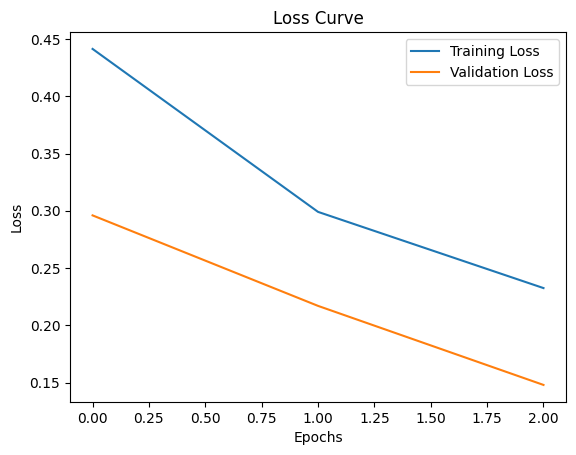

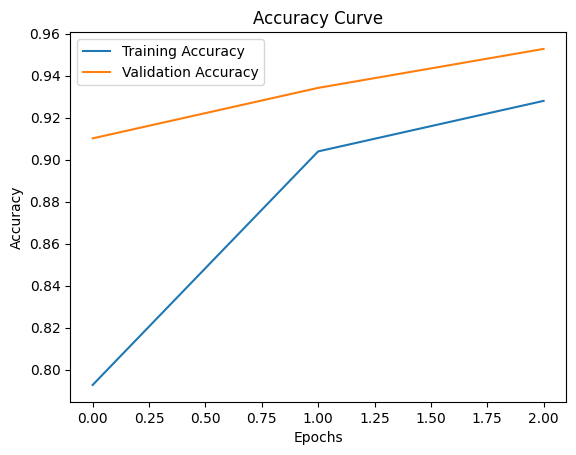

In [17]:
import matplotlib.pyplot as plt



plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load the original model
model = load_model("lstm_model.h5")

# Save in a format compatible with older Keras versions
model.save("converted_model.h5")  # or model.save("converted_model", save_format="tf")


In [23]:
from google.colab import files
files.download('lstm_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

import pickle

# Save the tokenizer
with open('tokenizer1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Import files and download it
from google.colab import files
files.download('tokenizer1.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>